In [1]:
import sys
path='/home/tomas/Ulmer-Berechnung/alps2qutipplus-april/alps2qutipplus-main/'

sys.path.insert(1, path) 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qutip
import scipy.linalg as linalg
import time
from multiprocessing import Pool
from itertools import product
from typing import Optional

import alpsqutip.parallelized_functions_and_workers as plME

from alpsqutip import (build_system, list_models_in_alps_xml,
                       list_geometries_in_alps_xml, graph_from_alps_xml,
                       model_from_alps_xml,
                       restricted_maxent_toolkit as me)

from alpsqutip.operators.states.utils import safe_exp_and_normalize ## function used to safely and robustly map K-states to states

from alpsqutip.scalarprod import fetch_covar_scalar_product
from alpsqutip.operators.states.gibbs import GibbsDensityOperator, GibbsProductDensityOperator

In [3]:

from alpsqutip.operators.arithmetic import (
    ScalarOperator,
    LocalOperator,
    OneBodyOperator,
    Operator,
    ProductOperator,
    ScalarOperator,
    SumOperator,
    QutipOperator
)

from alpsqutip.operators.simplify import simplify_sum_operator

In [4]:
params={}

params['size']=5
params['Jx']=1.; params['Jy'] = .75*params['Jx']; params['Jz']=1.05*params['Jx']

from scipy.optimize import root, fsolve
Ffactor=np.real(max(np.roots(np.poly1d([1, 0, -(params['Jx']*params['Jy']+params['Jx']*params['Jy']+params['Jy']*params['Jz']), 
                           -2*params['Jx']*params['Jy']*params['Jz']]))))
chi_y=fsolve(lambda x,y: x*np.arcsinh(x)-np.sqrt(x**2+1)-y, 1e-1, args=(0))[0]
vLR=4*Ffactor*chi_y



In [5]:
system=build_system(geometry_name= "open chain lattice",model_name="spin", 
                    L=params['size'], J=1)

sites=[s for s in system.sites]
sx_ops=[system.site_operator("Sx", '1[' + str(a) + ']') for a in range(len(system.sites))]
sy_ops=[system.site_operator("Sy", '1[' + str(a) + ']') for a in range(len(system.sites))]
sz_ops=[system.site_operator("Sz", '1[' + str(a) + ']') for a in range(len(system.sites))]

idop = [system.site_operator('identity@1[' + str(a) + ']') for a in range(len(system.sites))]
from functools import reduce
idop = reduce(Operator.__mul__, idop)

#Iz = sum(sz_ops)
H_nn = 0  # Proches voisins
H_lr = 0  # Longue portée

from itertools import combinations

for i, j in combinations(range(params['size']), 2):
    r = abs(i - j)
    Jx_ij = params['Jx'] / r**3
    Jy_ij = params['Jy'] / r**3
    Jz_ij = params['Jz'] / r**3

    term = (
        Jx_ij * sx_ops[i] * sx_ops[j]
        + Jy_ij * sy_ops[i] * sy_ops[j]
        + Jz_ij * sz_ops[i] * sz_ops[j]
    )

    if r == 1:
        H_nn += term  # Interaction de voisins immédiats
    else:
        H_lr += term  # Interaction à longue portée
        
H = H_nn 
H = H.simplify()

loading model spin  over graph open chain lattice


In [6]:
z = np.random.rand()
z

0.25960979255094097

In [7]:
obs_SzA = sum(sz for sz in sz_ops)
HBB0=[idop]+[sz for sz in sz_ops]

phi0 = np.array([.0] + [-1.5+np.random.rand() for _ in HBB0[1:]])

K0 = me.k_state_from_phi_basis(phi0, HBB0).simplify()
sigma0 = GibbsProductDensityOperator(K0)
phi0[0] = np.log(sigma0.tr())
K0 = me.k_state_from_phi_basis(phi0, HBB0).simplify()
sigma0 = GibbsProductDensityOperator(K0)

tgt_obs = obs_SzA
[(sigma0 * op).tr().real for op in sz_ops] 

[0.12441213591153855,
 0.2834442808239705,
 0.2909606088779031,
 0.12302077167023936,
 0.2693102140657545]

In [8]:
## exact dynamics

timespan=np.linspace(.0, 1200/vLR,600)
evs_obs_ex=qutip.mesolve(H=H.to_qutip(), rho0=sigma0.to_qutip(), tlist=timespan, e_ops=[tgt_obs.to_qutip()])

In [9]:
simulations={}
tgt_obs = obs_SzA
sp_local = fetch_covar_scalar_product(sigma0)

from scipy.linalg import cho_solve, cho_factor
       
simulations[1] = {
    "parms":{
    "chosen_depth": 6,
    "m0": 3,
    "eps": 0.5e-3,
    },
  "saved_cut_times_index_ell":[0],
   "no_acts_ell" : [0],
    "local_bound_error_ell":[],
    "spectral_norm_Hij_tensor_ell":[],
    "instantaneous_w_errors":[],
} 

current_simulation = simulations[1]
current_simulation_parms = current_simulation["parms"]
chosen_depth = current_simulation_parms["chosen_depth"]
eps_tol = current_simulation_parms["eps"]
m0 = current_simulation_parms["m0"]

In [10]:
local_bound_error_ell = []
simulations[1]["evs"] = [(sigma0 * tgt_obs).tr()]  # initial observable expectation

sp_local = fetch_covar_scalar_product(sigma=sigma0)
local_t_value = 0.0

# Initial bass construction and orthogonalization
HBB_ell_act = plME.parallelized_real_time_projection_of_hierarchical_basis(
    generator=H,
    seed_op=obs_SzA,
    sigma_ref=sigma0,
    m_max=m0,
    deep=chosen_depth,
    num_workers=12
)

orth_basis_act, R_act, Gram_matrix_act = plME.orthogonalize_basis_parallel_process(
    basis = HBB_ell_act,
    sp = sp_local, 
    max_workers =12
)

Hij_tensor_act_non_orth = plME.compute_Hij_tensor_non_orth(
    basis = HBB_ell_act, 
    generator = H, 
    sp = sp_local,
    sigma_ref = sigma0,
    m_max = m0,
    Gram = Gram_matrix_act,
            num_workers=12
)

Hij_tensor_act = (linalg.inv(R_act).T 
                  @ Hij_tensor_act_non_orth 
                  @ linalg.inv(R_act)) ### In this convention for R_act, the orthonormal Hij_orth is
                                       ### Hij_orth = (R**-1).T @ Hij_non_orth @ (R**-1)

phi0_proj_act = np.array([sp_local(tgt_obs, op) for op in orth_basis_act])
new_obs_local=sum(phi0a * opa for phi0a, opa in zip(phi0_proj_act, orth_basis_act)).simplify() ### same here
print("Fita: Check", ((new_obs_local.to_qutip() - tgt_obs.to_qutip())).norm())

for t in timespan[1:]:
    start = time.time()
    
    delta_t = t - local_t_value
    exp_H = linalg.expm(delta_t * Hij_tensor_act)
    phi_local = np.real(exp_H @ phi0_proj_act)
    
    print(f"A. phi-local {time.time() - start:.2f}s");    start = time.time()
    
    obs_local = sum(c * op for c, op in zip(phi_local, orth_basis_act)).simplify()
    
    print(f"B. obs-local {time.time() - start:.2f}s");    start = time.time()
    
    simulations[1]["evs"].append((sigma0.to_qutip() * obs_local.to_qutip()).tr())
    
    print(f"C. Ev {time.time() - start:.2f}s");    start = time.time()
    
    # Compute the local bound error ratio
    numerator = me.m_th_partial_sum(phi=phi_local, m=2)
    denominator = me.m_th_partial_sum(phi=phi_local, m=0)
    local_bound_error_ell.append(numerator / denominator)
    
    # Check if error is above threshold, trigger basis update
    if abs(local_bound_error_ell[-1]) >= eps_tol:
        local_t_value = t
        print(f"a. Renormalization at t={list(timespan).index(t)}")
        
        start = time.time()
        HBB_ell_act = plME.parallelized_real_time_projection_of_hierarchical_basis(
                generator=H,
                seed_op=obs_local,
                sigma_ref=sigma0,
                m_max=m0,
                deep=chosen_depth,
                num_workers=12
        )
        print(f"b. HBB_ell_act, {time.time() - start:.6f}s")
        
        start = time.time()
        
        orth_basis_act, R_act, Gram_matrix_act = plME.orthogonalize_basis_parallel_process(
            basis = HBB_ell_act,
            sp = sp_local, 
            max_workers =12
        )
        
        print(f"c. orth basis act, {time.time() - start:.6f}s")
        
        start = time.time()
        
        Hij_tensor_act_non_orth = plME.compute_Hij_tensor_non_orth(
            basis = HBB_ell_act, 
            generator = H, 
            sp = sp_local,
            sigma_ref = sigma0,
            m_max = m0,
            Gram = Gram_matrix_act,
            num_workers=12
        )
            
        print(f"d. Hij-tensor-act, {time.time() - start:.6f}s")
        Hij_tensor_act = linalg.inv(R_act).T @ Hij_tensor_act_non_orth @ linalg.inv(R_act)
        phi0_proj_act = np.array([sp_local(obs_local, op) for op in orth_basis_act])
        new_obs_local=sum(phi0a * opa for phi0a, opa in zip(phi0_proj_act, orth_basis_act)).simplify() ### same here
        print("Fita: Check", ((new_obs_local.to_qutip() - obs_local.to_qutip())).norm())
    else:
        # If error below tolerance, keep current basis and coefficients
        pass

Fita: Check 8.365063795723798e-15
A. phi-local 0.00s
B. obs-local 0.01s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.01s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.01s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
a. Renormalization at t=7
b. HBB_ell_act, 5.391996s
c. orth basis act, 18.393925s
d. Hij-tensor-act, 0.776972s
Fita: Check 5.1415662911768514e-15
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
a. Renormalization at t=13
b. HBB_ell_act, 6.603406s
c. orth basis act, 19.705605s
d. Hij-tensor-act, 0.786900s
Fita: Check 9.187048795854827e-15
A. phi-local 0.00s
B. ob

b. HBB_ell_act, 7.186679s
c. orth basis act, 22.500078s
d. Hij-tensor-act, 0.638761s
Fita: Check 8.745682775857562e-11
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
a. Renormalization at t=113
b. HBB_ell_act, 6.824688s
c. orth basis act, 22.046505s
d. Hij-tensor-act, 0.947218s
Fita: Check 2.1777269055616487e-10
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
a. Renormalization at t=118
b. HBB_ell_act, 7.195547s
c. orth basis act, 22.824371s
d. Hij-tensor-act, 0.649707s
Fita: Check 2.6643283510367726e-10
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.0

b. HBB_ell_act, 7.620794s
c. orth basis act, 22.059769s
d. Hij-tensor-act, 0.927853s
Fita: Check 0.0016948940685405736
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
a. Renormalization at t=216
b. HBB_ell_act, 7.561312s
c. orth basis act, 22.258822s
d. Hij-tensor-act, 0.983970s
Fita: Check 0.003032132443591272
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
a. Renormalization at t=221
b. HBB_ell_act, 8.051769s
c. orth basis act, 22.197687s
d. Hij-tensor-act, 0.910182s
Fita: Check 0.005246629808467641
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.00s
C. Ev 0.01s
A. phi-local 0.00s
B. obs-local 0.00s
C

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x76abd8525a90>>
Traceback (most recent call last):
  File "/home/tomas/miniconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 

KeyboardInterrupt



/tmp/ipykernel_136876/1931962303.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


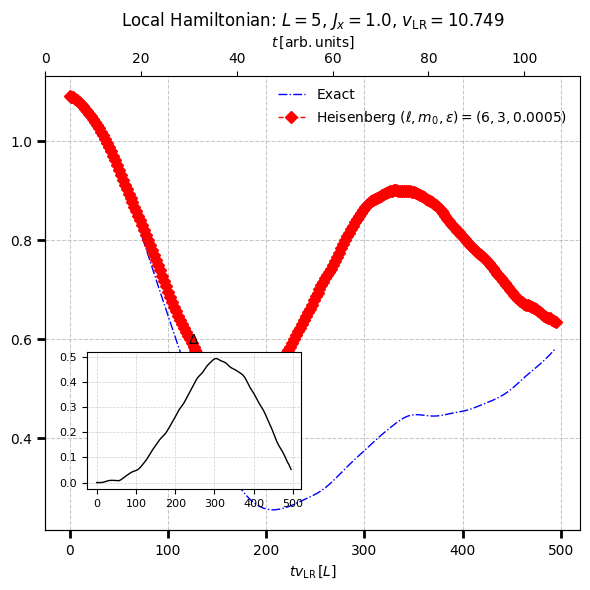

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Création de la figure et des axes principaux
fig, ax = plt.subplots(figsize=(6, 6))

n = 1
m = 248

# --- Courbe principale: observable exact + simulation ---
ax.plot(timespan[:m]*vLR, evs_obs_ex.expect[0][:m],
        label='Exact', color="blue", linestyle='dashdot', linewidth=1)

l = simulations[1]["parms"]["chosen_depth"]
m0 = simulations[1]["parms"]["m0"]
eps = simulations[1]["parms"]["eps"]

label_sim1 = fr'Heisenberg $(\ell, m_0, \epsilon) = ({l}, {m0}, {eps})$'
ax.plot(timespan[:m]*vLR, simulations[1]["evs"][:m],
        label=label_sim1, color='red', linestyle='--', marker='D', linewidth=1)

# --- Inset: Delta courbe ---
inset_ax = inset_axes(ax, width="40%", height="30%", loc='lower left', borderpad=3)
inset_ax.plot(timespan[:m]*vLR,
              abs(evs_obs_ex.expect[0][:m] - simulations[1]["evs"][:m]),
              color="black", linestyle='solid', linewidth=1)
inset_ax.set_title(r'$\Delta$', fontsize=10)
inset_ax.tick_params(labelsize=8)
inset_ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

# --- Style global ---
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(direction='out', length=6, width=2, which='major', grid_alpha=0.6)
ax.grid(True, which='major', linestyle='--', linewidth=0.75, alpha=0.7)
ax.legend(frameon=False, loc='upper right')

# Axe secondaire en haut
ax1 = ax.twiny()
ax1.set_xlim(timespan[0], timespan[-1])
ax.set_xlabel(r'$t v_{\rm LR} \, [L]$')
ax1.set_xlabel(r'$t \, [{\rm arb. units}]$')

# Titre
plt.title(r'Local Hamiltonian: $L={}$, $J_x={}$, $v_{{\rm LR}}={}$'.format(
    params['size'], 
    round(params['Jx'], 3), 
    round(vLR, 3)
))

plt.tight_layout()


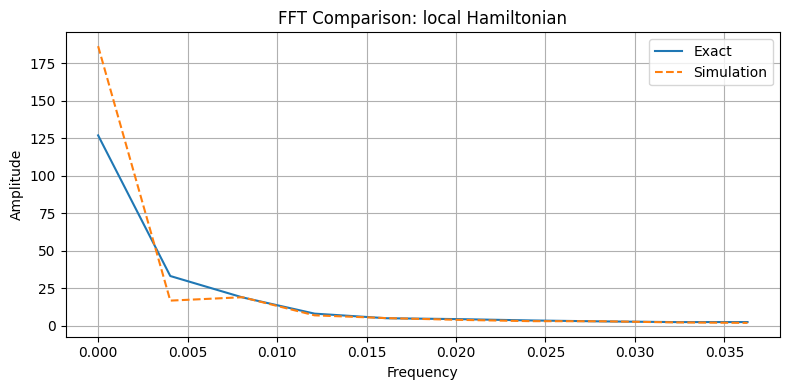

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Extract time series (length m)
exact_data = evs_obs_ex.expect[0][:m]
simulation_data = simulations[1]["evs"][:m]

# Use real FFT for speed & clarity
fft_vals_ex = np.fft.rfft(exact_data)
fft_vals_sim = np.fft.rfft(simulation_data)

# Frequency axis (assumes unit sampling interval, change d=1/fs if needed)
fft_freqs = np.fft.rfftfreq(m, d=1)

# Compute amplitudes
amplitude_ex = np.abs(fft_vals_ex)
amplitude_sim = np.abs(fft_vals_sim)

# Optional: focus on a frequency window (e.g., up to index 100)
max_index = 10  # Adjust as needed

# Plot
plt.figure(figsize=(8, 4))
plt.plot(fft_freqs[:max_index], amplitude_ex[:max_index], label="Exact")
plt.plot(fft_freqs[:max_index], amplitude_sim[:max_index], label="Simulation", linestyle='--')
plt.title("FFT Comparison: local Hamiltonian")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
(0.116-0.110)/0.110

0.05454545454545459